<a href="https://colab.research.google.com/github/nverchev/TrueSkill-step-by-step/blob/main/trueskill_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TrueSkill step by step
This notebook guides you through the Trueskill™ algorithm, a rating system developed by Microsoft for the Xbox gaming platform. This implementation is for educational purposes and explains the message-passing algorithm step by step using a traditional Bayesian vocabulary. It is not an implementation designed for efficiency or practical use. Note that the algorithm is under copyrights and that only non-commercial projects can freely use Truskill™.

This implementation adds a variable called "Luck" that replaces the initial convolution of the original algorithm. This modelling choice may be more intuitive to some and is mathematically equivalent. This implementation only covers a basic version of Trueskill with no game-specific variables. Many online resources explain how to extend it to the general setup and how the matchmaking criteria works. I name a few here:

- The original [paper](https://www.microsoft.com/en-us/research/publication/trueskilltm-a-bayesian-skill-rating-system/) about Trueskill
- The [infopage](https://www.microsoft.com/en-us/research/project/trueskill-ranking-system/) on microsoft.com
- A divulgation [article](http://www.moserware.com/2010/03/computing-your-skill.html), starting with a gentle introduction, by Jeff Moser
- The Python [implementation](https://trueskill.org/) by Heungsub Lee (I used this to check my code)
- Chapter 3 [Meeting your match](https://mbmlbook.com/TrueSkill.html) from Model-Based Machine Learning by John Winn

This notebook reproduces the examplein the last resource. We start by updating the ratings of Jill and Fred after their game. Then, we show how the multiplayer setting works by letting Steve join them in a new game.

This implementation is in Python 3.10.

In [1]:
from __future__ import annotations  # for annotating a class in its definition
import numpy as np
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt

LUCK_VARIANCE = 25
DRAW_MARGIN = 1  # No draws when 0
MAX_ITER = 2  # multiplayer only
TOLERANCE = 0  # not used when 0
NEW_GAME_VARIANCE = 0  # Skill is fixed when 0

## Class Definition
This implementation relies on classes rather than message passing. The classes defined here implement the assumptions and inference approach of the model.

In [29]:
# a variable following a Gaussian distribution with its standard properties
class GaussianVariable:

    def __init__(self, mu: float, sigma2: float):
        self.mu = mu
        self.sigma2 = sigma2
        self.sigma = np.sqrt(sigma2)

    # calculate its probability density function in x
    def pdf(self, x: float) -> float:
        return norm.pdf(x, self.mu, self.sigma)

    # calculate its cumulative distribution function in x
    def cdf(self, x: float) -> float:
        return norm.cdf(x, self.mu, self.sigma)

    # return the opposite variable
    def __neg__(self):
        return GaussianVariable(-self.mu, self.sigma2)

    # add an independent Gaussian variable
    def __add__(self, addend: GaussianVariable) -> GaussianVariable:
        assert isinstance(addend, GaussianVariable)
        return GaussianVariable(self.mu + addend.mu,
                                self.sigma2 + addend.sigma2)

    # subtract an independent Gaussian variable
    def __sub__(self, subtrahend: GaussianVariable) -> GaussianVariable:
        return self + (-subtrahend)

    # subtract an independent Gaussian variable
    def __sub__(self, subtrahend: GaussianVariable) -> GaussianVariable:
        return self + (-subtrahend)

    # left multiplication with float
    def __mul__(self, factor: float) -> GaussianVariable:
        return GaussianVariable(self.mu * factor, self.sigma2 * factor ** 2)

    # right multiplication with float
    def __rmul__(self, factor: float) -> GaussianVariable:
        return self.__mul__(factor)

    # division by float
    def __truediv__(self, divisor: float) -> GaussianVariable:
        return self.__mul__(1 / divisor)

    # Kullback-Leibler divergence (measure the approximation of self)
    def kld(self, approx: GaussianVariable) -> GaussianVariable:
        return np.log(approx.sigma / self.sigma) - 0.5 + \
              (self.sigma2 + (self.mu - approx.mu) ** 2) / (2 * approx.sigma2)

    # multiply the density with the density of another Gaussian variable.
    # return the Gaussian variable with the resulting density (normalized)
    def density_mult(self, factor: GaussianVariable) -> GaussianVariable:
        assert isinstance(factor, GaussianVariable)
        sigma2 = 1 / (1 / self.sigma2 + 1 / factor.sigma2)
        mu = (self.mu / self.sigma2 + factor.mu / factor.sigma2) * sigma2
        return GaussianVariable(mu, sigma2)

    # divide the density with the density of another Gaussian variable.
    # return the Gaussian variable with the resulting density (normalized)
    def density_div(self, divisor: GaussianVariable) -> GaussianVariable:
        assert isinstance(divisor, GaussianVariable)
        sigma2 = 1 / (1 / self.sigma2 - 1 / divisor.sigma2)
        mu = (self.mu / self.sigma2 - divisor.mu / divisor.sigma2) * sigma2
        return GaussianVariable(mu, sigma2)

    # print mean and variance
    def __repr__(self):
        return f'N(\u03BC={self.mu:.1f}, \u03c3\u00b2={self.sigma2:.1f})'


# variables related to a player
class Player:
    luck = GaussianVariable(0, LUCK_VARIANCE)  # replaces Performance - Skill
    new_game = GaussianVariable(0, NEW_GAME_VARIANCE)

    def __init__(self, name: str, rating_mu: float, rating_sigma2: float):
        self.name = name
        self.skill = GaussianVariable(rating_mu, rating_sigma2) + self.new_game
        # the prior distribution of the performance
        # is a Gaussian (Luck) centered on the variable Skill
        self.prior_perf = self.skill + self.luck
        # the likelihood factorized by messages
        self.likelihood_perf: GaussianVariable | None = None
        self.likelihood_skill: GaussianVariable | None = None

    # set performance and skill likelihood message
    def set_likelihood_perf(self, value):
        self.likelihood_perf = value
        self.likelihood_skill = value + self.luck

    # posterior of the skill
    def update_rating(self):
        if self.likelihood_skill is None:
            print('Skill remains unchanged.')
            return
        self.skill = self.skill.density_mult(self.likelihood_skill)
        # removes likelihood
        self.likelihood_skill = None

    # print name
    def __str__(self):
        return self.name

    # print player prior stats
    def __repr__(self):
        str_skill = f"{self.name}'s skill ~ {repr(self.skill)}"
        str_perf = f" and their expected performance ~ {repr(self.prior_perf)}"
        return str_skill + str_perf



# variables related to a team
# the default team performance is the sum of performance
class Team:

    def __init__(self, *players: Player, credits: list[float] | None = None):
        # Name the team after the first player
        self.name = "Team " + players[0].name
        self.players = players
        self.num_players = len(players)
        if credits is not None:
            if not self.num_players==len(credits):
                raise ValueError("Numbers of credits and player do not match")
            if not all([credit > 0 for credit in credits]):
                raise ValueError("Credits must be positive")
            self.credits = credits
        else:
            self.credits = [1 for _ in players]

        self.weighted_perf = [player.prior_perf * credit
                        for player, credit in zip(self.players, self.credits)]
        self.prior_perf: GaussianVariable = \
                                sum(self.weighted_perf, GaussianVariable(0, 0))
        # the likelihood factorized by messages
        self.likelihood_message: list[GaussianVariable | None] = [None, None]
        # the posterior of performance after message
        self.perf_after_message: list[GaussianVariable] = 2 * [self.prior_perf]

    # set likelihood message and new posterior
    def set_likelihood_message(self, index, value):
        self.likelihood_message[index] = value
        self.perf_after_message[index] = self.prior_perf.density_mult(value)

    # performance likelihood given the incoming likelihood messages
    def get_likelihood_perf(self) -> GaussianVariable | None:
        if self.likelihood_message[0] is None:
            return self.likelihood_message[1]
        if self.likelihood_message[1] is None:
            return self.likelihood_message[0]
        return self.likelihood_message[0].density_mult(\
                                                    self.likelihood_message[1])

    # weighted performances without indexed player
    def exclude_player(self, index:int) -> list[GaussianVariable]:
        return self.weighted_perf[:index] + self.weighted_perf[index+1:]

    # updates the player nodes
    def update_players(self):
        team_perf = self.get_likelihood_perf()
        for i, player in enumerate(self.players):
            other_players_perf = self.exclude_player(i)
            # removes other player perf from team perf and divide by credit
            minus_other = map(lambda x: -x, other_players_perf)
            player_perf = sum(minus_other, team_perf) / self.credits[i]
            player.set_likelihood_perf(player_perf)

    # print name
    def __str__(self):
        return self.name

    # print team prior stats
    def __repr__(self):
        return f"{self.name}'s expected performance ~ {repr(self.prior_perf)}"

# pairwise confrontations like Steve vs Fred or Fred vs Jill
class Pairwise:
    draw_margin = DRAW_MARGIN

    def __init__(self, team1: Team, team2: Team):
        self.name = f"{team1} vs {team2}"
        # result
        self.team1 = team1
        self.team2 = team2
        # prior of the performance difference
        self.perf_diff_prior = self.get_context()
        # winning probability at the start of the match for player1
        self.win_prob = 1 - self.perf_diff_prior.cdf(self.draw_margin)
        # drawing probability at the start of the match
        self.draw_prob = self.perf_diff_prior.cdf(self.draw_margin) \
                                  - self.perf_diff_prior.cdf(-self.draw_margin)
        self.result_draw = None
        # approximated with expectation propagation
        self.approx_posterior = None
        self.approx_likelihood = None

    # set the result from team1 perspective
    def set_result(self, team1_wins: bool | None = None, draw: bool = False):
        if draw:
            self.result_draw = True
            if team1_wins is not None:
                raise ValueError(f'Either {self.team1} wins or it is a draw')
        else:
            self.result_draw = False
            if team1_wins is None:
                raise ValueError(f'Insert the outcome of the confrontation')
            elif not team1_wins:
                # if it is not a draw, team1 is the one winning
                self.switch_teams()

    # switches the team so that team1 is the winner and updates
    def switch_teams(self):
        self.team1, self.team2 = self.team2, self.team1
        self.perf_diff_prior = - self.perf_diff_prior
        self.win_prob = 1 - self.win_prob

    # current estimation of the performance difference
    def get_context(self) -> GaussianVariable:
        return \
            self.team1.perf_after_message[0] - self.team2.perf_after_message[1]

    # propagate likelihood back to player
    def propagate(self) -> float:
        new_message = self.team2.perf_after_message[1] + self.approx_likelihood
        # we only keep the kld of the loser' message for the stopping criteria
        kld = self.team2.perf_after_message[1].kld(new_message)
        self.team1.set_likelihood_message(1, new_message)
        new_message = self.team2.perf_after_message[0] + self.approx_likelihood
        self.team2.set_likelihood_message(0, new_message)
        return kld

    # expectation propagation approximation for likelihood
    def expectation_propagation(self):
        context = self.get_context()
        # calculate the mean and variance of the "exact" posterior
        epsilon = self.draw_margin / context.sigma
        nu, omega = self.nu_and_omega(context.mu / context.sigma, epsilon)
        post_mu = context.sigma * nu + context.mu
        post_sigma2 = context.sigma2 * (1 - omega)
        # moment matching
        self.approx_posterior = GaussianVariable(post_mu, post_sigma2)
        # ep strategy
        self.approx_likelihood = self.approx_posterior.density_div(context)

    # calculate correction terms for the posterior mean and variance
    def nu_and_omega(self, x: float, epsilon:float) -> tuple[float, float]:
        if self.result_draw is None:
            raise RuntimeError("You have to set the result before inference")
        if self.result_draw:
            return self.nu_and_omega_draw(x, epsilon)
        return self.nu_and_omega_win(x, epsilon)

    # formula for the winning case
    @staticmethod
    def nu_and_omega_win(x: float, epsilon:float) -> tuple[float, float]:
        # x_win greater than 0 means player1 wins
        x_win =  x - epsilon
        nu = norm.pdf(x_win) / norm.cdf(x_win)
        omega = nu * (nu + x_win)
        return (nu, omega)

    # formula for the drawing case
    @staticmethod
    def nu_and_omega_draw(x: float, epsilon:float) -> tuple[float, float]:
        # x_win greater than 0 means player1 wins
        x_win =  x - epsilon
        # x_lose greater than 0 means player1 loses
        x_lose =  - (x + epsilon)
        n_win = norm.pdf(x_win)
        n_lose = norm.pdf(x_lose)
        num = n_lose - n_win
        den = norm.cdf(-x_win) - norm.cdf(x_lose)
        nu = num / den
        omega = (nu ** 2) - (x_win * n_win + x_lose * n_lose) / den
        return (nu, omega)

    def plot_posterior_approx(self):
        if self.approx_posterior is None:
            raise RuntimeError("Expectation propagation not called")
        center = int(self.approx_posterior.mu)
        radius = int(self.approx_posterior.sigma) * 3
        a = np.arange(center - radius, center + radius * 1)
        if self.result_draw:
            possible_values = abs(a) <= self.draw_margin
            normalize = self.draw_prob
        else:
            possible_values = a > self.draw_margin
            normalize = self.win_prob
        pdf_renorm = self.perf_diff_prior.pdf(a) / normalize
        pdf_exact = np.where(possible_values, pdf_renorm, 0)
        pdf_approx = self.approx_posterior.pdf(a)
        plt.cla()
        plt.plot(a, pdf_exact, color="blue", label="Exact")
        plt.plot(a, pdf_approx, color="green", label="Approx")
        plt.xlabel('Performance difference', fontsize=20)
        plt.ylabel('Posterior density', fontsize=20)
        plt.legend(fontsize=15, loc='upper right')
        plt.show()

    def plot_likelihood_approx(self):
        if self.approx_posterior is None:
            raise RuntimeError("Expectation propagation not called")
        center = int(self.approx_likelihood.mu)
        radius = int(self.approx_likelihood.sigma) * 3
        a = np.arange(center - radius, center + radius * 1)
        pdf_exact = np.where(a < self.draw_margin, 1, 0)
        pdf_approx = self.approx_likelihood.pdf(a)
        plt.cla()
        plt.plot(a, pdf_exact, color="blue", label="Exact")
        plt.plot(a, pdf_approx, color="green", label="Approx")
        plt.xlabel('Performance difference', fontsize=20)
        plt.ylabel('Likelihood', fontsize=20)
        plt.legend(fontsize=15, loc='upper right')
        plt.show()

    # print name
    def __str__(self):
        return self.name

    # print team prior stats
    def __repr__(self):
        return "\n".join([self.name + ":",
                    f"Winning probability {self.team1}: {self.win_prob:.2f}",
                    f"Probability of a draw: {self.draw_prob:.2f}",])


class Match:
    luck = LUCK_VARIANCE
    max_iter = MAX_ITER
    tolerance = TOLERANCE

    def __init__(self, teams: tuple[Team] or list[Team],
                 pairwise_list: list(Pairwise) | None = None):
        self.teams = sorted(teams, key=lambda x: x.prior_perf.mu, reverse=True)
        self.multiplayer = len(teams) > 2
        if pairwise_list is None:
            # the default pairing is based on their expected performance
            self.pairwise_list = [Pairwise(team1, team2)
                          for team1, team2 in zip(self.teams, self.teams[1:])]
        else:
            self.pairwise_list = pairwise_list

    # transform a ranking into pairwise confrontations
    # e.g. [(1st vs 2nd), (2nd vs 3rd), ...]
    @classmethod
    def from_ranking(cls, ranking: tuple[tuple[Team]]) -> list[Pairwise]:
        # get list of teams
        teams = sum(ranking, ())
        pairwise_confrontations = []
        winner = ranking[0][0]
        for place, next_place in zip(ranking, ranking[1:]):
            # draws
            for team1, team2 in zip(place, place[1:]):
                pairwise = Pairwise(team1, team2)
                pairwise.set_result(draw=True)
                pairwise_confrontations.append(pairwise)
            # wins
            pairwise = Pairwise(place[-1], next_place[0])
            pairwise.set_result(team1_wins=True)
            pairwise_confrontations.append(pairwise)
        return cls(teams, pairwise_confrontations)


    # perform expectation_propagation until stopping criteria
    def update_differentials(self):
        iter = self.max_iter if self.multiplayer else 1
        for _ in range(iter):
          for pairwise in self:
              pairwise.expectation_propagation()
              kld = pairwise.propagate()
              if self.tolerance:
                  if kld < self.tolerance and self.tolerance:
                      return

    # update the ratings of the players
    def inference(self):
      self.update_differentials()
      for team in self.teams:
          team.update_players()
          for player in team.players:
              player.update_rating()

    # calculate the match quality which is better when draws are likely
    def calculate_match_quality(self):
        num_pairs = len(self)
        origin = np.zeros(num_pairs)
        mu_vec = np.empty(num_pairs)
        var_mat = np.empty((num_pairs, num_pairs))
        norm_mat = np.empty((num_pairs, num_pairs))
        for i, pair in enumerate(self):
            mu_vec[i] = pair.perf_diff_prior.mu
            var_mat[i, i] = pair.perf_diff_prior.sigma2
            norm_team1 = sum((credit ** 2 for credit in pair.team1.credits))
            norm_team2 = sum((credit ** 2 for credit in pair.team2.credits))
            norm_mat[i, i] = self.luck * (norm_team1 + norm_team2)
            if i != num_pairs - 1:
                sigma2_team2 = pair.team2.prior_perf.sigma2
                var_mat[i, i + 1] = var_mat[i + 1, i] = sigma2_team2
                norm_mat[i, i + 1] = norm_mat[i + 1, i] = self.luck * norm_team2
        quality_variable = multivariate_normal(mean=mu_vec, cov=var_mat)
        norm = multivariate_normal.pdf(origin, mean=origin, cov=norm_mat)
        return quality_variable.pdf(origin) / norm

    # iterate through the confrontations
    def __iter__(self):
        return self.pairwise_list.__iter__()

    # length is number of teams - 1
    def __len__(self):
      return len(self.pairwise_list)

## Updating a game of two players

Here Jill wins against Fred. To allow draws, change the `DRAW_MARGIN` variable.

In [3]:
# players
Fred = Player("Fred", rating_mu=100, rating_sigma2=25)
Jill = Player("Jill", rating_mu=120, rating_sigma2=1600)
print("Before seeing the outcome of the game:")
print(repr(Fred))
print(repr(Jill))

# game outcome
Jill_wins = True

# teams only contain one player
TeamJ = Team(Jill)
TeamF = Team(Fred)

J_vs_F = Pairwise(TeamJ, TeamF)
print(repr(J_vs_F))
print(f"The expected performance difference ~ {J_vs_F.perf_diff_prior}")

J_vs_F.set_result(team1_wins=Jill_wins)
# J_vs_F.set_result(draw=True)

# approximate the likelihood with expectation propagation
J_vs_F.expectation_propagation()
print("We approximate the performance difference with", J_vs_F.approx_posterior)
print("The approximated likelihood =", J_vs_F.approx_likelihood)

# send the likelihood back to the player
J_vs_F.propagate()
TeamJ.update_players()
TeamF.update_players()

for player in (Fred, Jill):
    print("Name:", player.name)
    print("Approximated performance likelihood =", player.likelihood_perf)
    print("Approximated skill likelihood =", player.likelihood_skill)
    player.update_rating()
    print("New rating is", player.skill)

Before seeing the outcome of the game:
Fred's skill ~ N(μ=100.0, σ²=25.0) and their expected performance ~ N(μ=100.0, σ²=50.0)
Jill's skill ~ N(μ=120.0, σ²=1600.0) and their expected performance ~ N(μ=120.0, σ²=1625.0)
Team Jill vs Team Fred:
Winning probability Team Jill: 0.68
Probability of a draw: 0.02
The expected performance difference ~ N(μ=20.0, σ²=1675.0)
We approximate the performance difference with N(μ=41.6, σ²=798.2)
The approximated likelihood = N(μ=61.3, σ²=1524.9)
Name: Fred
Approximated performance likelihood = N(μ=161.3, σ²=1574.9)
Approximated skill likelihood = N(μ=161.3, σ²=1599.9)
New rating is N(μ=100.9, σ²=24.6)
Name: Jill
Approximated performance likelihood = N(μ=161.3, σ²=1574.9)
Approximated skill likelihood = N(μ=161.3, σ²=1599.9)
New rating is N(μ=140.6, σ²=800.0)


## Plots

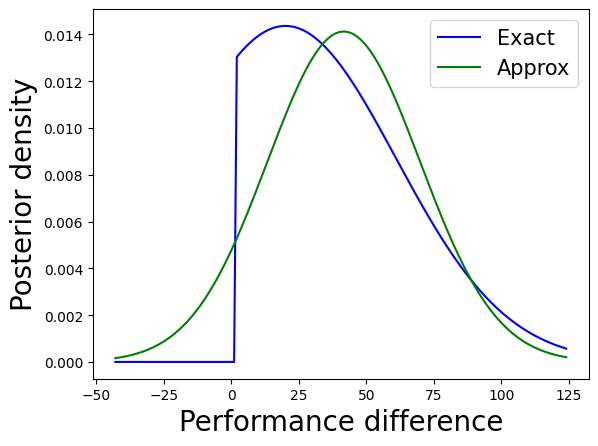

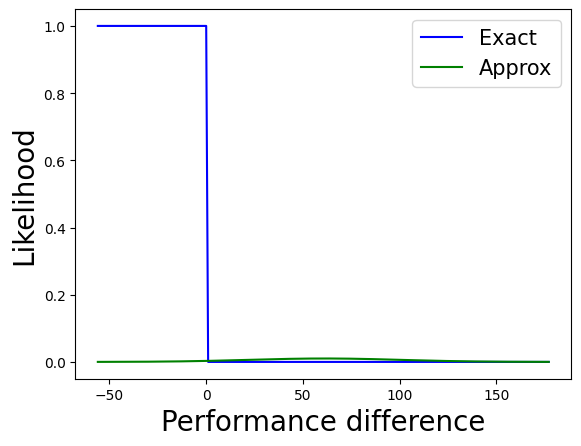

In [4]:
# the optimal approximation according to KL divergence but here is implicit
J_vs_F.plot_posterior_approx()

# This is not a numerical approximation, but it approximates the effect on the graph.
J_vs_F.plot_likelihood_approx()

## Three players game
We consider a third player, Steve. This time we create the pairwise confrontation from a ranking. To allow for draws, you need a positive `DRAW_MARGIN`

In [5]:
players=[
    Player("Fred", rating_mu=100, rating_sigma2=25),
    Player("Jill", rating_mu=120, rating_sigma2=1600),
    Player("Steve", rating_mu=140, rating_sigma2=1600)]

team_dict = {player.name: Team(player) for player in players}

# set players first (winner) to last (loser)
# players draw if they are in the same tuple in the ranking
ranking = ((team_dict['Jill'], ), (team_dict['Fred'], ), (team_dict['Steve'], ))

# divide the ranking into pairwise confrontations (contained in game_match)
game_match = Match.from_ranking(ranking)

for _ in range(MAX_ITER):
    for pairwise in game_match:
        pairwise.expectation_propagation()
        pairwise.propagate()
    for team in team_dict.values():
        print(repr(team))
        print("Likelihood messages:", team.likelihood_message)
        print("Performance posterior per likelihood:", team.perf_after_message)

for team in team_dict.values():
    team.update_players()
    for player in team.players:
        print("Name:", player)
        print("Approximated performance likelihood =", player.likelihood_perf)
        print("Approximated skill likelihood =", player.likelihood_skill)
        player.update_rating()
        print("New rating is", player.skill)

Team Fred's expected performance ~ N(μ=100.0, σ²=50.0)
Likelihood messages: [N(μ=161.3, σ²=1574.9), N(μ=178.5, σ²=2054.7)]
Performance posterior per likelihood: [N(μ=101.9, σ²=48.5), N(μ=101.9, σ²=48.8)]
Team Jill's expected performance ~ N(μ=120.0, σ²=1625.0)
Likelihood messages: [None, N(μ=161.3, σ²=1574.9)]
Performance posterior per likelihood: [N(μ=120.0, σ²=1625.0), N(μ=141.0, σ²=799.8)]
Team Steve's expected performance ~ N(μ=140.0, σ²=1625.0)
Likelihood messages: [N(μ=178.5, σ²=2054.7), None]
Performance posterior per likelihood: [N(μ=157.0, σ²=907.4), N(μ=140.0, σ²=1625.0)]
Team Fred's expected performance ~ N(μ=100.0, σ²=50.0)
Likelihood messages: [N(μ=162.2, σ²=1500.2), N(μ=178.5, σ²=2055.6)]
Performance posterior per likelihood: [N(μ=102.0, σ²=48.4), N(μ=101.9, σ²=48.8)]
Team Jill's expected performance ~ N(μ=120.0, σ²=1625.0)
Likelihood messages: [None, N(μ=162.2, σ²=1500.6)]
Performance posterior per likelihood: [N(μ=120.0, σ²=1625.0), N(μ=141.9, σ²=780.2)]
Team Steve's ex

## Teams with more than one player:
This should give the same output as in the two player game because Suzanne and Steve have almost zero credit.

In [7]:
# team up two players
team_list = [Team(Player("Fred", rating_mu=100, rating_sigma2=25),
                  Player("Suzanne", rating_mu=140, rating_sigma2=25),
                  credits=[1., 0.00001]),
            Team(Player("Jill", rating_mu=120, rating_sigma2=1600),
                  Player("Steve", rating_mu=140, rating_sigma2=1600),
                  credits=[1., 0.00001])]

team_dict = {team.name: team for team in team_list}

# team name after the first player
ranking = ((team_dict['Team Jill'], ), (team_dict['Team Fred'], ))

# ranking works as before
game_match = Match.from_ranking(ranking)

for pairwise in game_match:
    pairwise.expectation_propagation()
    pairwise.propagate()
for team in team_dict.values():
    print(repr(team))
    print("Performance posterior per likelihood:", team.perf_after_message)

for team in team_dict.values():
    team.update_players()
    for player in team.players:
        print("Name:", player)
        print("Approximated performance likelihood =", player.likelihood_perf)
        print("Approximated skill likelihood =", player.likelihood_skill)
        player.update_rating()
        print("New rating is", player.skill)

Team Fred's expected performance ~ N(μ=100.0, σ²=50.0)
Performance posterior per likelihood: [N(μ=101.9, σ²=48.5), N(μ=100.0, σ²=50.0)]
Team Jill's expected performance ~ N(μ=120.0, σ²=1625.0)
Performance posterior per likelihood: [N(μ=120.0, σ²=1625.0), N(μ=141.0, σ²=799.8)]
Name: Fred
Approximated performance likelihood = N(μ=161.3, σ²=1574.9)
Approximated skill likelihood = N(μ=161.3, σ²=1599.9)
New rating is N(μ=100.9, σ²=24.6)
Name: Suzanne
Approximated performance likelihood = N(μ=6126033.0, σ²=16248812495671.7)
Approximated skill likelihood = N(μ=6126033.0, σ²=16248812495696.7)
New rating is N(μ=140.0, σ²=25.0)
Name: Jill
Approximated performance likelihood = N(μ=161.3, σ²=1574.9)
Approximated skill likelihood = N(μ=161.3, σ²=1599.9)
New rating is N(μ=140.6, σ²=800.0)
Name: Steve
Approximated performance likelihood = N(μ=4126033.0, σ²=31998812495671.7)
Approximated skill likelihood = N(μ=4126033.0, σ²=31998812495696.7)
New rating is N(μ=140.0, σ²=1600.0)


## Example use
We show how you can use the classes above to quickly perform inference.

In [9]:
team_list = [Team(Player("Fred", rating_mu=100, rating_sigma2=25),
                Player("Suzanne", rating_mu=140, rating_sigma2=25),
                credits=[1., 0.00001]),
            Team(Player("Jill", rating_mu=120, rating_sigma2=1600),
                Player("Steve", rating_mu=140, rating_sigma2=1600),
                credits=[1., 0.00001])]

team_dict = {team.name: team for team in team_list}

# players draw if they are in the same team_dict in the ranking
ranking = ((team_dict['Team Jill'], ), (team_dict['Team Fred'], ))

# represent the performance differences between players
game_match = Match.from_ranking(ranking)
game_match.inference()
print(team_dict['Team Jill'].players[0].__repr__())

Jill's skill ~ N(μ=140.6, σ²=800.0) and their expected performance ~ N(μ=120.0, σ²=1625.0)


## Match quality
You can calculate the match quality to select the best opponent(s).
The results changes on the ranking. We assume that the ranking follows the
expected perforfomances of the teams before the game is played.

WARNING: The match quality calculation has not been fully tested.

In [32]:
players=[
    Player("Fred", rating_mu=100, rating_sigma2=25),
    Player("Jill", rating_mu=120, rating_sigma2=1600),
    Player("Steve", rating_mu=140, rating_sigma2=1600)]

team_list = [Team(player) for player in players]

# represent the performance differences between players
game_match = Match(team_list)
quality_metric = game_match.calculate_match_quality()
print(f"Evaluated quality for this match; {quality_metric: .3f}")

Evaluated quality for this match;  0.023
